In [1]:
!pip install scikit-garden
!pip install setuptools numpy scipy scikit-learn cython

  Using cached scikit-garden-0.1.3.tar.gz (317 kB)
  Running setup.py clean for scikit-garden
Failed to build scikit-garden
    Running setup.py install for scikit-garden: started
    Running setup.py install for scikit-garden: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Wayne Linn\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Wayne Linn\\AppData\\Local\\Temp\\pip-install-6a8ac02w\\scikit-garden\\setup.py'"'"'; __file__='"'"'C:\\Users\\Wayne Linn\\AppData\\Local\\Temp\\pip-install-6a8ac02w\\scikit-garden\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Wayne Linn\AppData\Local\Temp\pip-wheel-g82r6zi2'
       cwd: C:\Users\Wayne Linn\AppData\Local\Temp\pip-install-6a8ac02w\scikit-garden\
  Complete output (164 lines):
  Appending skgarden.mondrian.tree configuration to skgarden.mondrian
  Ignoring attempt to set 'name' (from 'skgarden.mondrian' to 'skgarden.mondrian.tree')
  Appending skgarden.mondrian.ensemble configuration to skgarden.mondrian
  Ignoring attempt to set 'name' (from 'skg

In [2]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from skgarden import RandomForestQuantileRegressor

import warnings
warnings.filterwarnings("ignore")

C:\Users\Wayne Linn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Wayne Linn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. Import the train datasets

In [3]:
X_train = pd.read_csv("data-train.csv",index_col=0)
Y_train = X_train.sales
X_train = X_train.drop(['sales'],axis=1)

In [4]:
Model_1 = RandomForestQuantileRegressor(n_estimators=100)

# 2. Setup Pipeline (Not Used)

# Quantile Regression Forest is not stable and does not work well with GridSearchCV

In [5]:

RG = Model_1

In [6]:
pipe = Pipeline(steps=[("RG",RG)])

In [7]:
param_grid = {
    #"pca__n_components": [50, 100,170]
}

# 3. Setup GridSearch (Not Used)

In [8]:
score_metric = 'neg_mean_squared_error'
search = GridSearchCV(pipe,param_grid,
                      n_jobs=-1,
                      cv=10,
                      scoring=score_metric)

In [9]:
search.fit(X_train,Y_train.values.ravel())

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
df = pd.DataFrame(search.cv_results_)
df = df.sort_values(by=['rank_test_score'])
df

# 4. Best Hyperparameter (Not Used)

In [ ]:
parms = pd.DataFrame(df['params'])
for i in parms.iloc[0]:
    print(i)

# 5. Evaluate Model 

In [10]:

best_n_est=1000

In [11]:
Model_2 = RandomForestQuantileRegressor(n_estimators=best_n_est)

In [12]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X_train,Y_train,test_size=0.2,random_state=132)


In [13]:
RG1 = Model_2
RG1.fit(X_train1,Y_train1.values.ravel())

RandomForestQuantileRegressor(n_estimators=1000)

In [14]:
MSE(RG1.predict(X_test1),Y_test1)

314.90921677321813

In [15]:
result = pd.DataFrame(Y_test1)

In [16]:
result["Predicted_sales"] = RG1.predict(X_test1)

In [17]:
MSE(result["sales"],result["Predicted_sales"])

314.90921677321813

# 6. Inventory Decision

In [18]:
residual = result['sales']-result['Predicted_sales']

In [19]:
Price=20
Cost=12
Salvage=8
Over=Cost - Salvage
Under=Price - Cost
Over, Under

(4, 8)

### QQ plot to explore the distribution of residual

#### Normal Distribution

In [20]:
import scipy.stats as sct

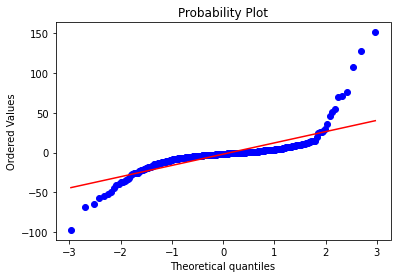

In [21]:
import scipy
scipy.stats.probplot(residual, dist="norm", plot=plt)
plt.show()

In [22]:
s = residual.std()
opt_dec_N=np.ceil(sct.norm.ppf(Under/(Under+Over))*s + result['Predicted_sales'])

#### Exponential Distribution

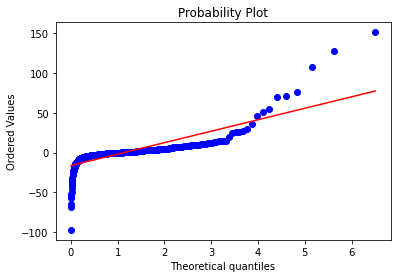

In [23]:
scipy.stats.probplot(residual, dist="expon", plot=plt)
plt.show()

In [24]:
opt_dec_E=np.ceil((-result['Predicted_sales'])*np.log(1-(Under/(Under+Over))))

#### Empirical Distribution

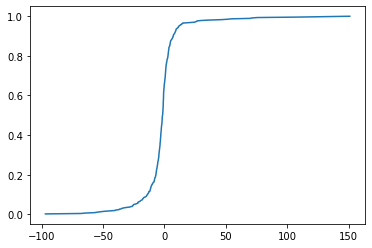

In [25]:
size = residual.shape[0]
step=1/size
jumps = [step*i for i in range(1,size+1)]
Sample = sorted(residual)
plt.plot(Sample,jumps)

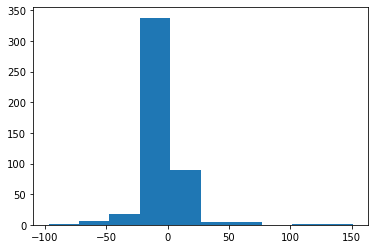

In [26]:
plt.hist(Sample)
plt.show()

In [27]:
def inv(sample,jump,area):
    size = len(sample)
    i=0
    temp=jump[i]
    while temp<area:
        i+=1
        temp=jump[i]
        
    return sample[i]

In [28]:
offset = inv(Sample,jumps,2/3)
offset

0.1849999999999996

In [29]:
opt_dec_B = np.ceil(result['Predicted_sales']+offset)

# 7. Out-of-samples Profit

In [30]:
#max profit for test data set
max_profit = result['sales'].sum()*(Price-Cost)
max_profit

82096

In [31]:
def profit(demand,inv):
    return (Price-Salvage)*np.minimum(demand,inv)-(Cost-Salvage)*inv

In [32]:
#Profit (Normal)
profit_lst_N = profit(result['sales'],opt_dec_N)
profit_lst_N.sum()

52912.0

In [33]:
#Profit (Exponential)
profit_lst_E = profit(result['sales'],opt_dec_E)
profit_lst_E.sum()

59700.0

In [34]:
#Profit (Empirical)
profit_lst_B = profit(result['sales'],opt_dec_B)
profit_lst_B.sum()

60024.0

# 8. K-Fold Cross Validation

### Repeat steps 5,6,7 with 10-fold cross validation

In [35]:
Model_4= Model_2 = RandomForestQuantileRegressor(n_estimators=best_n_est)

In [36]:
from sklearn.model_selection import KFold
k=10
kf = KFold(n_splits=k)
X_train_t=X_train.to_numpy()
Y_train_t=Y_train.to_numpy()
model = []
mse_lst = []
max_profit_lst = []
profit_N_lst = []
profit_E_lst = []
profit_B_lst = []

for train_index,test_index in kf.split(X_train_t):
    X_train_K,X_test_K=X_train_t[train_index],X_train_t[test_index]
    Y_train_K,Y_test_K=Y_train_t[train_index],Y_train_t[test_index]
    
    
    #Model
    RG_K = Model_4
    RG_K.fit(X_train_K,Y_train_K.ravel())
    
    #MSE
    mse_lst.append(MSE(RG_K.predict(X_test_K),Y_test_K))
    
    #Transform log(sale) back to sale
    result_K = pd.DataFrame(Y_test_K)
    result_K["Predicted_sales"] = RG_K.predict(X_test_K)
    
    #Obtain residual
    residual_K = result_K[0]-result_K['Predicted_sales']
    
    #Get std for Normal distribution
    s_K = residual.std()
    
    #Inventory Decision (Normal)
    opt_dec_N_K=np.ceil(sct.norm.ppf(Under/(Under+Over))*s_K + result_K['Predicted_sales'])
    #Inventory Decision (Exponential)
    opt_dec_E_K=np.ceil((-result_K['Predicted_sales'])*np.log(1-(Under/(Under+Over))))
    
    #Inventory Decision (Empirical Distribution)
    size_K = residual_K.shape[0]
    step_K=1/size_K
    jumps_K = [step_K*i for i in range(1,size+1)]
    Sample_K = sorted(residual_K)
    offset_K = inv(Sample_K,jumps_K,2/3)
    opt_dec_B_K = np.ceil(result_K['Predicted_sales']+offset_K)
    
    #Out-of_sample profit
    profit_lst_B_K = profit(result_K[0],opt_dec_B_K)
    profit_B_lst.append(profit_lst_B_K.sum())
    
    profit_lst_N_K = profit(result_K[0],opt_dec_N_K)
    profit_N_lst.append(profit_lst_N_K.sum())
    
    profit_lst_E_K = profit(result_K[0],opt_dec_E_K)
    profit_E_lst.append(profit_lst_E_K.sum())
    
    max_profit_K = result_K[0].sum()*(Price-Cost)
    max_profit_lst.append(max_profit_K)
    
max_profit_lst = np.array(max_profit_lst)
profit_N_lst = np.array(profit_N_lst)
profit_E_lst = np.array(profit_E_lst)
profit_B_lst = np.array(profit_B_lst)

fraction_of_max_N = profit_N_lst/max_profit_lst
fraction_of_max_E = profit_E_lst/max_profit_lst
fraction_of_max_B = profit_B_lst/max_profit_lst

dist_profit = ["Normal","Exponential","Empirical","Max"]
dist_frac = ["Normal","Exponential","Empirical"]
col_name = ["Dataset_"+str(i) for i in range(1,k+1)]

profit_lst = [profit_N_lst,profit_E_lst,profit_B_lst,max_profit_lst]
profit_table = pd.DataFrame(profit_lst,index=dist_profit,columns=col_name)
profit_table["mean_profit"]=profit_table.mean(axis=1)
profit_table["std_profit"]=profit_table.std(ddof=1,axis=1)

fraction_lst = [fraction_of_max_N,fraction_of_max_E,fraction_of_max_B]
fraction_table = pd.DataFrame(fraction_lst,index=dist_frac,columns=col_name)
fraction_table["mean_fraction"]=fraction_table.mean(axis=1)

In [37]:
fraction_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5,Dataset_6,Dataset_7,Dataset_8,Dataset_9,Dataset_10,mean_fraction
Normal,0.692828,0.699576,0.646535,0.678712,0.652780,0.682647,0.700702,0.674935,0.643611,0.654149,0.672648
Exponential,0.779045,0.754905,0.716174,0.746953,0.727317,0.769002,0.759353,0.724978,0.708572,0.740204,0.742650
Empirical,0.786777,0.752077,0.717384,0.738627,0.711604,0.772075,0.745875,0.725239,0.714298,0.739435,0.740339


In [38]:
profit_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5,Dataset_6,Dataset_7,Dataset_8,Dataset_9,Dataset_10,mean_profit,std_profit
Normal,28672.0,31660.0,29932.0,31628.0,32404.0,26656.0,34312.0,31128.0,28772.0,27244.0,30240.8,2291.836504
Exponential,32240.0,34164.0,33156.0,34808.0,36104.0,30028.0,37184.0,33436.0,31676.0,30828.0,33362.4,2157.463103
Empirical,32560.0,34036.0,33212.0,34420.0,35324.0,30148.0,36524.0,33448.0,31932.0,30796.0,33240.0,1868.278352
Max,41384.0,45256.0,46296.0,46600.0,49640.0,39048.0,48968.0,46120.0,44704.0,41648.0,44966.4,3203.875254


In [39]:
profit_table.to_csv(".\\Model_Selection_Result\\5.1_Quantile_regression_forest(No_PCA).csv")

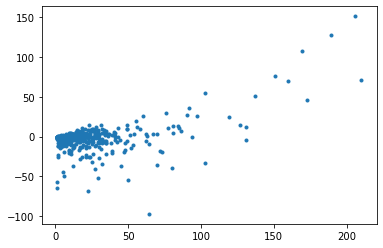

In [40]:
plt.plot(result['sales'],residual,".")